# 2021-05-19 Looking into some of the issues identified in the previous diary entry

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/5ca99a8e9fadbc12851080e5e2ed6cca9fd40a2a

(Rerunning the code below for other commits is not guaranteed to give the same results)


## Init

In [1]:
# clear the namespace
%reset -f

# put root folder of repo PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

C:\GITHUB\COMMOTIONSFramework


In [2]:
# imports needed to run the simulations
import numpy as np
import commotions
from importlib import reload  
import sc_scenario
reload(sc_scenario)
from sc_scenario import get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:89: UserWarning: N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.
  warnings.warn('N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.')


## Just the base model - no interaction

This is just to verify that the standstill problem noted in 2021-01-16 has been fixed now - it was caused by `T_acc = inf` values yielding `nan` returns from `sc_scenario_helper.get_value_of_const_jerk_interval()` - I have now added a hardcoded maximum of 3600 s in `SCAgent.get_access_order_values_for_agent_v02()` which is where the problem was located.

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:190: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1007: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 1)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1013: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured,

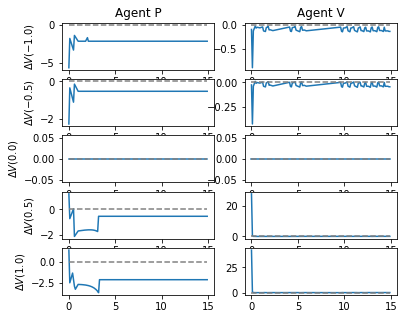

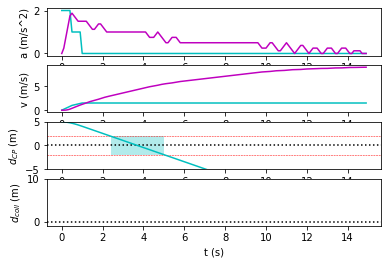

In [3]:
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = False, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True, surplus_action_vals = True)

## `oBEvs`

Reverting back to the baseline kinematical scenario and enabling `oBEvs`. Still getting the same behaviour as in the previous diary entries for this scenario, but now I have fixed a few things which gave the weird behaviour estimates mentioned in the 2021-01-16 entry:
* Needed to consider stopping just after exiting the CS as a possible means of passing first, to properly deal with cases where the other agent is moving very slowly toward the CS - in order make the code realise that just accelerating to free speed is the more sensible thing to do in this kind of situation - previously the code instead opted for a very slow near-infinite deceleration, that would have the ego agent ultimately reverse back to be at the CS exit just as the other agent entered it, a very long time into the future.
* When estimating the value for the other agent of an action/behaviour combination, that shouldn't be the max across both outcomes, as for the ego agent, but rather the value of the outcome corresponding to the behaviour in question for the other agent.

Below we now get sensible behaviour probabilities for the pedestrian agent in the 1-3 s time interval. If not doing anything, or slowing down, the pedestrian believes the car will pass first. If speeding up, the pedestrian believes the car will pass second:

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:190: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1007: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 1)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:1013: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured,

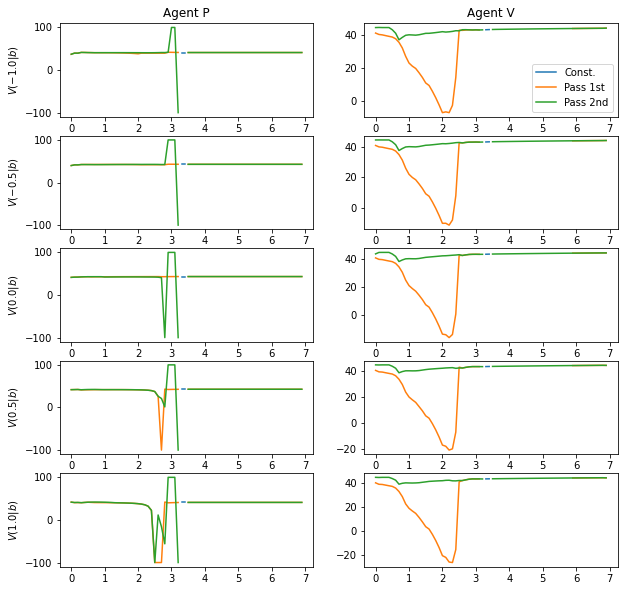

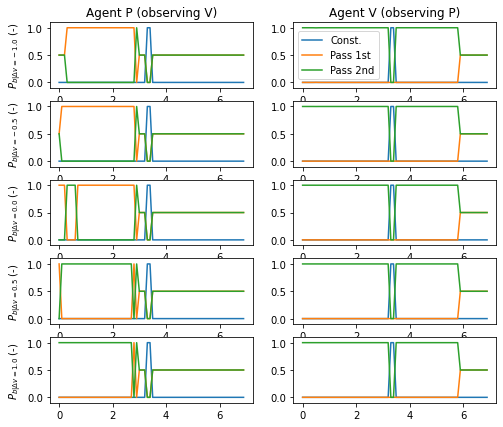

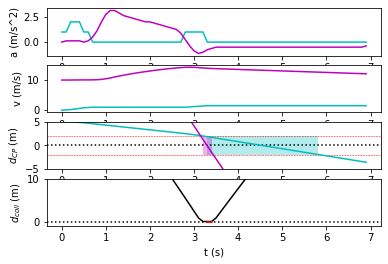

In [4]:
INITIAL_POSITIONS = np.array([[0,-5], [40, 0]])
SPEEDS = np.array((0, 10))

(params, params_k) = sc_scenario.get_default_params()
params.V_ny = 0
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = True, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 7, optional_assumptions = optional_assumptions,
        params = params, agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = False, surplus_action_vals = False, action_vals = True)

As noted in various places previously, it seems a little puzzling that the pedestrian still doesn't speed up to encourage the car to pass in second - that should be the better outcome, no? However, looking more deeply into the situation above, I now understand why this happens in the model, as currently formulated. The prediction of the future state with a given action-behaviour combination is just a prediction $T_p$ into the future, not into a later future where, for example, a yielding car has come to a full stop. So the two predictions for the car having the behaviours of passing first or second, respectively, will be slightly different, but at 1.5 s (for example) in the simulation above, even if the predicted speed for the "Pass 2nd" behaviour is slightly lower than for the "Pass 1st" behaviour, both speeds are still quite high, such that the higher-value access order for the pedestrian themselves is still "ego 2nd" for both behaviours, which means that regardless of the behaviour of the car, the pedestrian sees a future where they will come to a full stop before the CS, such that there is no difference between the two car behaviours, from the pedestrian's perspective. This can be seen above in the value plots (top figure), where for example at 1.5 s the pedestrian's $V(0.5|b)$ is the same for both car behaviours - i.e., this is the value that the pedestrian ascribes to the predicted future where they come to a full stop before the CS.

**An interesting corollary to the above would seem to be that if I add the delay costs for waiting, those values should diverge, because if the pedestrian is anyway going to stop and let the car pass first, then they should prefer the car to keep up the speed, to minimise the waiting time. That could be a nice next thing to try.**

Another slightly weird thing is the slight collision above - due to the pedestrian speeding up and the car slowing down at about 2.8 s. I think it has to do with the car just being about to reach the CS, such that the predicted position of the car might for example be predicted to be beyond the CS if speeding up to pass first, or inside it if decelerating to pass 2nd - this might cause some weirdness.